In [461]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [462]:
df = pd.read_csv('Data/Australian Vehicle Prices.csv')
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

Number of rows: 16734
Number of columns: 19


In [463]:
print(df.head(2).to_markdown())

|    | Brand     |   Year | Model   | Car/Suv              | Title                                     | UsedOrNew   | Transmission   | Engine       | DriveType   | FuelType   | FuelConsumption   |   Kilometres | ColourExtInt   | Location       | CylindersinEngine   | BodyType   | Doors   | Seats   |   Price |
|---:|:----------|-------:|:--------|:---------------------|:------------------------------------------|:------------|:---------------|:-------------|:------------|:-----------|:------------------|-------------:|:---------------|:---------------|:--------------------|:-----------|:--------|:--------|--------:|
|  0 | Ssangyong |   2022 | Rexton  | Sutherland Isuzu Ute | 2022 Ssangyong Rexton Ultimate (awd)      | DEMO        | Automatic      | 4 cyl, 2.2 L | AWD         | Diesel     | 8.7 L / 100 km    |         5595 | White / Black  | Caringbah, NSW | 4 cyl               | SUV        | 4 Doors | 7 Seats |   51990 |
|  1 | MG        |   2022 | MG3     | Hatchback            | 202

#  Data Cleaning

In [464]:
#Focus is on Used Cars. Let's keep only the rows where the 'New/Used' column is 'USED'
df = df[df['UsedOrNew'] == 'USED']
#Drop the 'UsedOrNew' column
df.drop('UsedOrNew', axis=1, inplace=True)
#Rename Kilomtres to Kilometers
df.rename(columns={'Kilometres': 'Kilometers'}, inplace=True)
#Drop Title
df.drop('Title', axis=1, inplace=True)

In [465]:
#Print number of rows where at least one element is missing
print('Number of rows with missing values:', df.isnull().any(axis=1).sum(), 'out of', df.shape[0], 'rows. This is', round(df.isnull().any(axis=1).sum()/df.shape[0]*100, 2), '% of the data.')

Number of rows with missing values: 1477 out of 14994 rows. This is 9.85 % of the data.


In [466]:
#Print number of missing values in each column
pd.concat([df.nunique(), df[df.isnull().any(axis=1)].nunique()], axis=1, keys=['Unique Values (All)', 'Unique Values (Missing)'])

,Unique Values (All),Unique Values (Missing)
Brand,70,53
Year,45,40
Model,724,281
Car/Suv,410,397
Transmission,3,3
Engine,91,11
DriveType,5,5
FuelType,9,8
FuelConsumption,153,2
Kilometers,14003,1434


In [467]:
print('Missing values are failry distributed and are not conentrated to specific values in columns.  It is safe to remove rows with missing values. This still leaves us with ', df.dropna().shape[0], 'rows of data.')

Missing values are failry distributed and are not conentrated to specific values in columns.  It is safe to remove rows with missing values. This still leaves us with  13517 rows of data.


In [468]:
df = df.dropna()
print('Number of rows with missing values:', df.isnull().any(axis=1).sum())

Number of rows with missing values: 0


In [469]:
print(df.head().to_markdown())

|    | Brand         |   Year | Model   | Car/Suv   | Transmission   | Engine       | DriveType   | FuelType   | FuelConsumption   |   Kilometers | ColourExtInt   | Location          | CylindersinEngine   | BodyType   | Doors   | Seats   |   Price |
|---:|:--------------|-------:|:--------|:----------|:---------------|:-------------|:------------|:-----------|:------------------|-------------:|:---------------|:------------------|:--------------------|:-----------|:--------|:--------|--------:|
|  1 | MG            |   2022 | MG3     | Hatchback | Automatic      | 4 cyl, 1.5 L | Front       | Premium    | 6.7 L / 100 km    |           16 | Black / Black  | Brookvale, NSW    | 4 cyl               | Hatchback  | 5 Doors | 5 Seats |   19990 |
|  2 | BMW           |   2022 | 430I    | Coupe     | Automatic      | 4 cyl, 2 L   | Rear        | Premium    | 6.6 L / 100 km    |         8472 | Grey / White   | Sylvania, NSW     | 4 cyl               | Coupe      | 2 Doors | 4 Seats |  108988 |


In [470]:
#Cleaning Data
#Engine column is in 4 cyl, 2.2 L format. There already is CylindersinEngine column. We only need the engine size
df['EngineSize'] = df['Engine'].str.split(', ').str[1].str.replace(' L', '')
#Remove ' cyl' from CylindersinEngine column
df['CylindersinEngine'] = df['CylindersinEngine'].str.replace(' cyl', '')
#FuelConsumption is in 8.7 L/100 km format. We only need the ratio
df['FuelConsumption(L per 100km)'] = df['FuelConsumption'].str.split(' ').str[0]
#Exterior colour
df['ExteriorColour'] = df['ColourExtInt'].str.split(' / ').str[0].replace('-', None)
#Remove ' Doors' from Doors column
df['Doors'] = df['Doors'].str.replace(' Doors', '')
#Remove ' Seats' from Seats column
df['Seats'] = df['Seats'].str.replace(' Seats', '')
#Location is in City, State format. We only need the State
df['Location'] = df['Location'].str.split(', ').str[1]
#Drop columns
df.drop(columns=['Engine', 'FuelConsumption', 'ColourExtInt'], inplace=True)
#If values in Price can't be converted to Int, drop the row
df = df[df['Price'].str.isnumeric()]
#Replace '-' with None in all columns
df.replace('-', None, inplace=True)
df.head()

,Brand,Year,Model,Car/Suv,Transmission,DriveType,FuelType,Kilometers,Location,CylindersinEngine,BodyType,Doors,Seats,Price,EngineSize,FuelConsumption(L per 100km),ExteriorColour
1,MG,2022.0,MG3,Hatchback,Automatic,Front,Premium,16,NSW,4,Hatchback,5,5,19990,1.5,6.7,Black
2,BMW,2022.0,430I,Coupe,Automatic,Rear,Premium,8472,NSW,4,Coupe,2,4,108988,2,6.6,Grey
3,Mercedes-Benz,2011.0,E500,Coupe,Automatic,Rear,Premium,136517,NSW,8,Coupe,2,4,32990,5.5,11,White
4,Renault,2022.0,Arkana,SUV,Automatic,Front,Unleaded,1035,NSW,4,SUV,4,5,34990,1.3,6,Grey
6,Land,2017.0,Rover,SUV,Automatic,AWD,Diesel,67662,NSW,4,SUV,2,4,62280,2,5.1,White


In [471]:
#Drop rows with missing values
df = df.dropna()
print('Number of rows remaining:', df.shape[0])

Number of rows remaining: 13072


In [472]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13072 entries, 1 to 16733
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Brand                         13072 non-null  object 
 1   Year                          13072 non-null  float64
 2   Model                         13072 non-null  object 
 3   Car/Suv                       13072 non-null  object 
 4   Transmission                  13072 non-null  object 
 5   DriveType                     13072 non-null  object 
 6   FuelType                      13072 non-null  object 
 7   Kilometers                    13072 non-null  object 
 8   Location                      13072 non-null  object 
 9   CylindersinEngine             13072 non-null  object 
 10  BodyType                      13072 non-null  object 
 11  Doors                         13072 non-null  object 
 12  Seats                         13072 non-null  object 
 13  Price 

In [473]:
#Change data types
df['Year'] = df['Year'].astype(int)
df['Kilometers'] = df['Kilometers'].str.replace(',', '').astype(int)
df['CylindersinEngine'] = df['CylindersinEngine'].astype(int)
df['Doors'] = df['Doors'].astype(int)
df['Seats'] = df['Seats'].astype(int)
df['Price'] = df['Price'].astype(int)
df['EngineSize'] = df['EngineSize'].astype(float)  
df['FuelConsumption(L per 100km)'] = df['FuelConsumption(L per 100km)'].astype(float)

In [474]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13072 entries, 1 to 16733
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Brand                         13072 non-null  object 
 1   Year                          13072 non-null  int64  
 2   Model                         13072 non-null  object 
 3   Car/Suv                       13072 non-null  object 
 4   Transmission                  13072 non-null  object 
 5   DriveType                     13072 non-null  object 
 6   FuelType                      13072 non-null  object 
 7   Kilometers                    13072 non-null  int64  
 8   Location                      13072 non-null  object 
 9   CylindersinEngine             13072 non-null  int64  
 10  BodyType                      13072 non-null  object 
 11  Doors                         13072 non-null  int64  
 12  Seats                         13072 non-null  int64  
 13  Price 

In [475]:
print(df.head().to_markdown())

|    | Brand         |   Year | Model   | Car/Suv   | Transmission   | DriveType   | FuelType   |   Kilometers | Location   |   CylindersinEngine | BodyType   |   Doors |   Seats |   Price |   EngineSize |   FuelConsumption(L per 100km) | ExteriorColour   |
|---:|:--------------|-------:|:--------|:----------|:---------------|:------------|:-----------|-------------:|:-----------|--------------------:|:-----------|--------:|--------:|--------:|-------------:|-------------------------------:|:-----------------|
|  1 | MG            |   2022 | MG3     | Hatchback | Automatic      | Front       | Premium    |           16 | NSW        |                   4 | Hatchback  |       5 |       5 |   19990 |          1.5 |                            6.7 | Black            |
|  2 | BMW           |   2022 | 430I    | Coupe     | Automatic      | Rear        | Premium    |         8472 | NSW        |                   4 | Coupe      |       2 |       4 |  108988 |          2   |                     

In [476]:
print(df.describe().to_markdown())

|       |       Year |   Kilometers |   CylindersinEngine |        Doors |       Seats |    Price |   EngineSize |   FuelConsumption(L per 100km) |
|:------|-----------:|-------------:|--------------------:|-------------:|------------:|---------:|-------------:|-------------------------------:|
| count | 13072      |      13072   |         13072       | 13072        | 13072       |  13072   | 13072        |                    13072       |
| mean  |  2015.77   |     106657   |             4.47361 |     4.01545  |     5.11605 |  33292.4 |     2.43648  |                        7.80337 |
| std   |     4.7436 |      75488.4 |             1.0657  |     0.685426 |     1.10801 |  27527.9 |     0.874985 |                        2.1507  |
| min   |  1978      |          1   |             2       |     2        |     2       |     88   |     0.7      |                        0       |
| 25%   |  2013      |      50429.8 |             4       |     4        |     5       |  17990   |     2       

In [477]:
#Zero Fuel Consumption is not possible. Remove rows with 0 Fuel Consumption
df = df[df['FuelConsumption(L per 100km)'] != 0]
#Let's remove Year below 1990 as they are considered classic cars. It is better to analyze them separately if enough data is available.
df = df[df['Year'] >= 1990]
#Let's keep the cars with price above $1000
df = df[df['Price'] >= 1000]
print('Number of rows remaining:', df.shape[0])

Number of rows remaining: 12922


In [478]:
#Let's analyze the data where kilometers are less than 25, the car is used and the year is less than 2022
print(df[(df['Kilometers'] < 25) & (df['Year'] < 2022)].to_markdown())
print('It is highly unlikely that a car has less than 25 kilometers on it and bought before 2022 and is used. Let\'s remove these rows.')
df = df[~((df['Kilometers'] < 25) & (df['Year'] < 2022))]
print('Number of rows remaining:', df.shape[0])

|       | Brand      |   Year | Model   | Car/Suv   | Transmission   | DriveType   | FuelType   |   Kilometers | Location   |   CylindersinEngine | BodyType   |   Doors |   Seats |   Price |   EngineSize |   FuelConsumption(L per 100km) | ExteriorColour   |
|------:|:-----------|-------:|:--------|:----------|:---------------|:------------|:-----------|-------------:|:-----------|--------------------:|:-----------|--------:|--------:|--------:|-------------:|-------------------------------:|:-----------------|
| 12618 | Holden     |   2016 | Captiva | SUV       | Automatic      | Front       | Unleaded   |            1 | NT         |                   4 | SUV        |       4 |       7 |   15990 |          2.4 |                            9   | Blue             |
| 13296 | Mitsubishi |   2021 | Eclipse | SUV       | Automatic      | Front       | Unleaded   |            1 | SA         |                   4 | SUV        |       4 |       5 |   34990 |          1.5 |                     

In [479]:
df.nunique()

Brand                              60
Year                               33
Model                             591
Car/Suv                            10
Transmission                        2
DriveType                           5
FuelType                            5
Kilometers                      12241
Location                            8
CylindersinEngine                   8
BodyType                           10
Doors                               4
Seats                              10
Price                            2733
EngineSize                         56
FuelConsumption(L per 100km)      149
ExteriorColour                     18
dtype: int64

In [480]:
#Let's drop Model and Car/Suv. They have too many unique values. Also, these values can be inferred from other columns such as DriveType, clyindersinEngine, etc.
df.drop(columns=['Model', 'Car/Suv'], inplace=True)

In [481]:
print(df.head().to_markdown())

|    | Brand         |   Year | Transmission   | DriveType   | FuelType   |   Kilometers | Location   |   CylindersinEngine | BodyType   |   Doors |   Seats |   Price |   EngineSize |   FuelConsumption(L per 100km) | ExteriorColour   |
|---:|:--------------|-------:|:---------------|:------------|:-----------|-------------:|:-----------|--------------------:|:-----------|--------:|--------:|--------:|-------------:|-------------------------------:|:-----------------|
|  1 | MG            |   2022 | Automatic      | Front       | Premium    |           16 | NSW        |                   4 | Hatchback  |       5 |       5 |   19990 |          1.5 |                            6.7 | Black            |
|  2 | BMW           |   2022 | Automatic      | Rear        | Premium    |         8472 | NSW        |                   4 | Coupe      |       2 |       4 |  108988 |          2   |                            6.6 | Grey             |
|  3 | Mercedes-Benz |   2011 | Automatic      | Rear   

# Exploratory Analysis

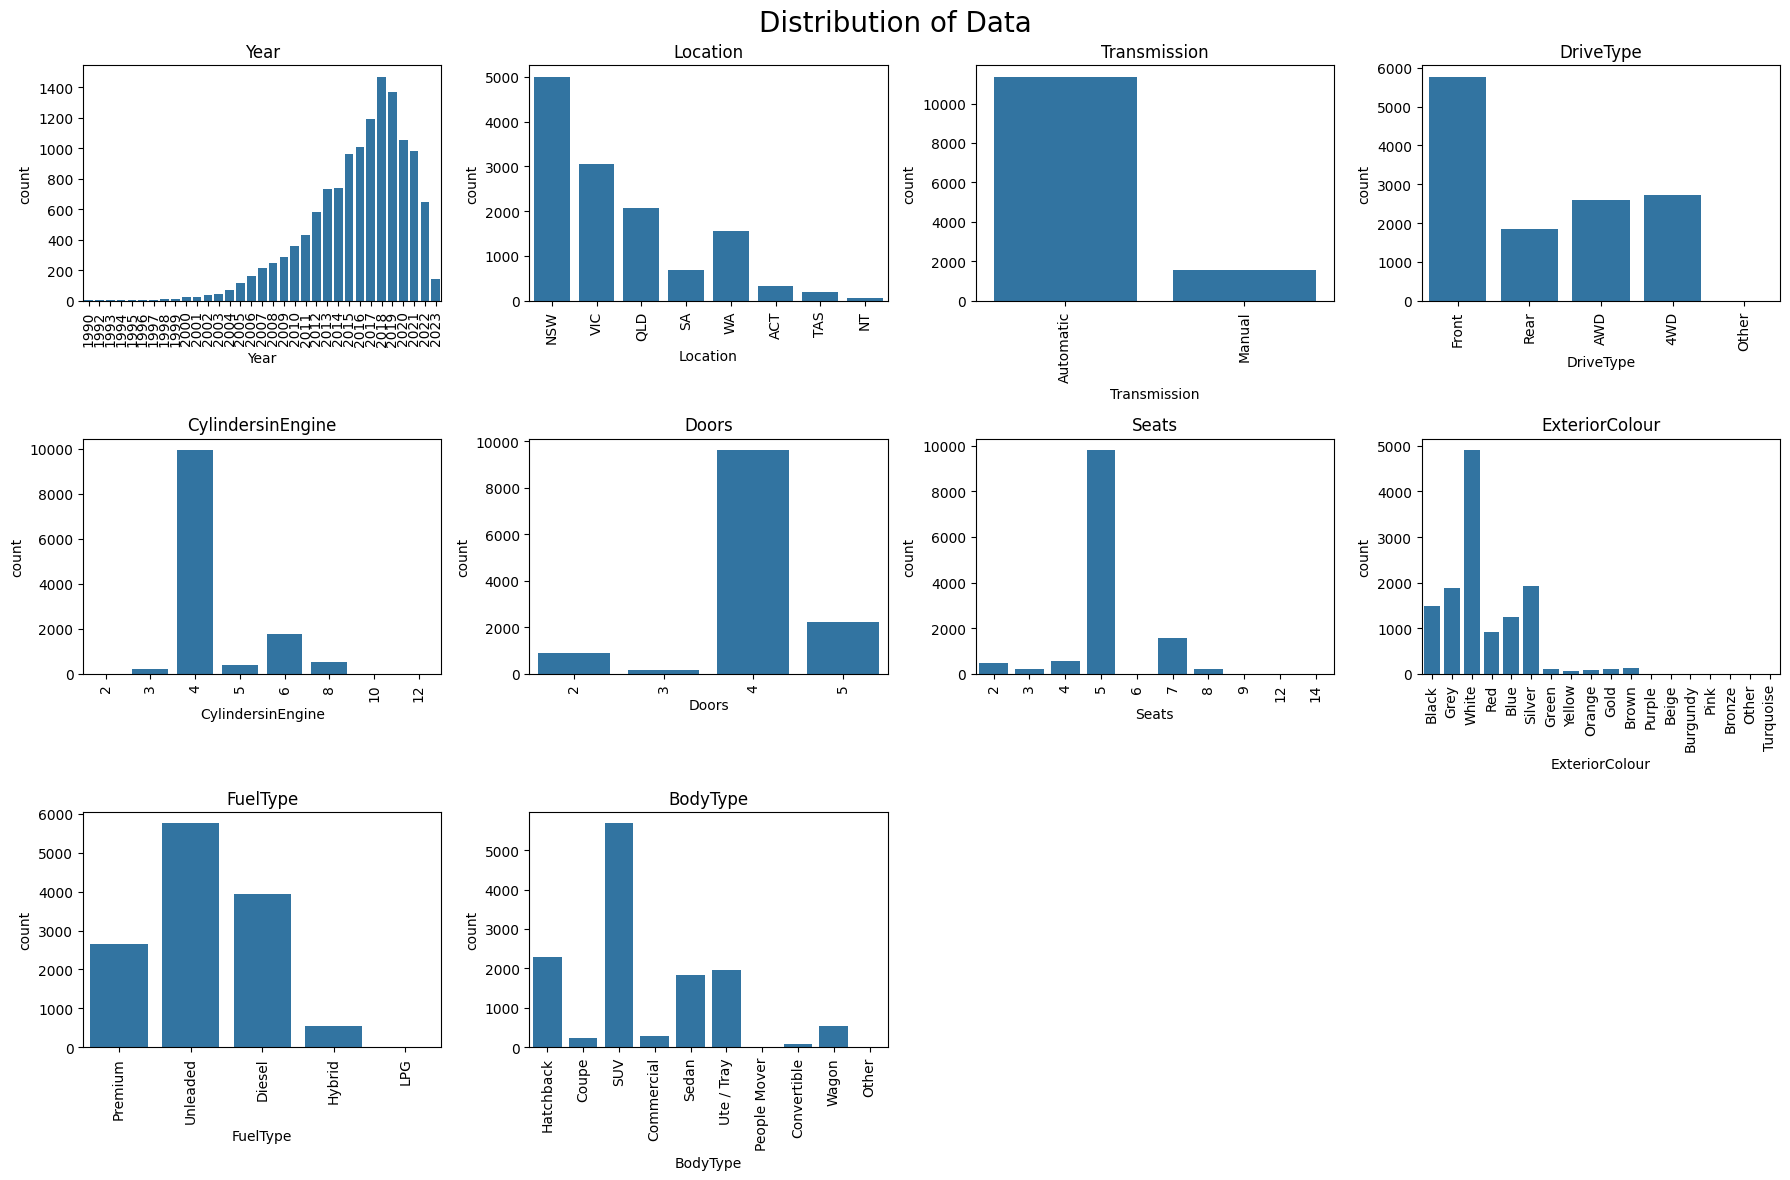

In [482]:
#Let's do some exploratory data analysis
#Plot of records by all columns except Price and Kilometers and FuelConsumption
columns = ['Year', 'Location', 'Transmission', 'DriveType', 'CylindersinEngine', 'Doors', 'Seats', 'ExteriorColour', 'FuelType', 'BodyType']
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle('Distribution of Data', fontsize=20)

for ax, col in zip(axes.flatten(), columns):
    plot = sns.countplot(ax=ax, data=df, x=col)
    ax.set_title(col)  # Optional: add a title for each subplot
    for label in ax.get_xticklabels():
        label.set_rotation(90)

#Remove empty subplot
fig.delaxes(axes.flatten()[11])
fig.delaxes(axes.flatten()[10])

plt.tight_layout()
plt.show()

In [483]:
#Drive type can't be Other. Let's remove those rows
df = df[df['DriveType'] != 'Other']
#Do the same for ExteriorColour
df = df[df['ExteriorColour'] != 'Other']
print('Number of rows remaining:', df.shape[0])

Number of rows remaining: 12917


In [484]:
df.head(2)

,Brand,Year,Transmission,DriveType,FuelType,Kilometers,Location,CylindersinEngine,BodyType,Doors,Seats,Price,EngineSize,FuelConsumption(L per 100km),ExteriorColour
1,MG,2022,Automatic,Front,Premium,16,NSW,4,Hatchback,5,5,19990,1.5,6.7,Black
2,BMW,2022,Automatic,Rear,Premium,8472,NSW,4,Coupe,2,4,108988,2.0,6.6,Grey


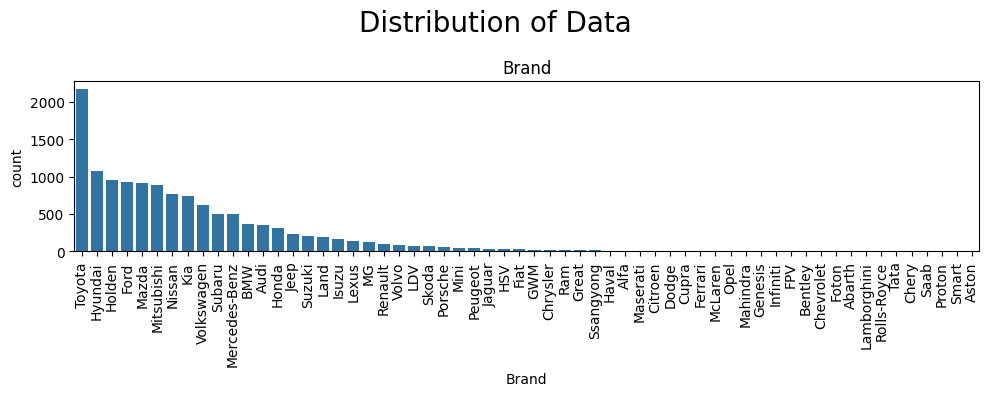

In [485]:
#Plot count by Brand and BodyType
fig, axes = plt.subplots(figsize=(10, 4))
fig.suptitle('Distribution of Data', fontsize=20)

# Plot count by Brand
plot = sns.countplot(data=df, x='Brand', order=df['Brand'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Brand')
plt.tight_layout()
plt.show()

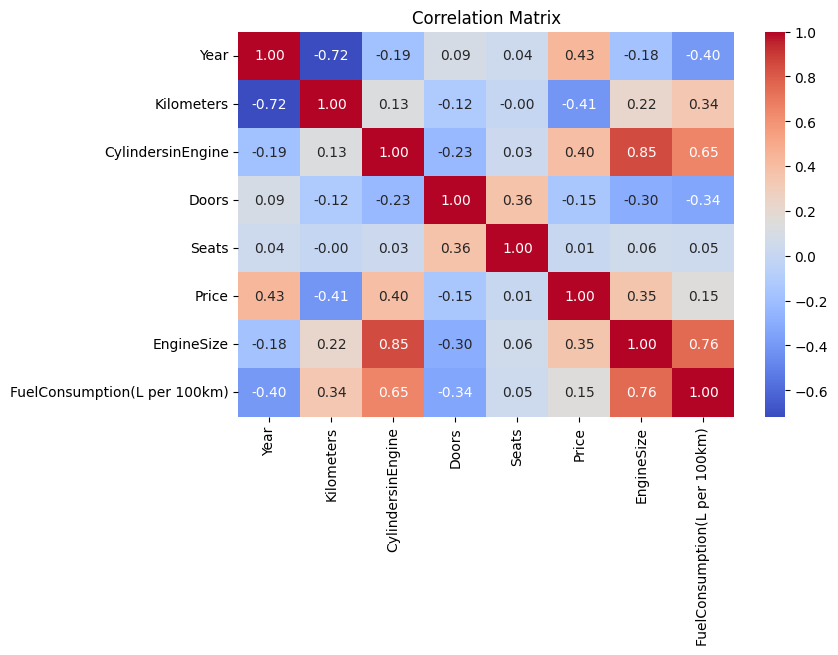

In [486]:
#Correlation Matrix
plt.figure(figsize=(8, 5))
sns.heatmap(df[['Year', 'Kilometers', 'CylindersinEngine', 'Doors', 'Seats', 'Price', 'EngineSize', 'FuelConsumption(L per 100km)']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [487]:
print('Year and Kilometers are strongly correlated. This is expected as older cars have more kilometers on them. However let\'s keep both since these two are important factors in deciding the price.')
print('CylindersinEngine, EngineSize, and FuelConsumption(L per 100km) are also correlated. We will keep CylindersinEngine and FuelConsumption.')
print('Drop Droors and Seats')
df.drop(columns=['EngineSize', 'Doors', 'Seats'], inplace=True)

Year and Kilometers are strongly correlated. This is expected as older cars have more kilometers on them. However let's keep both since these two are important factors in deciding the price.
CylindersinEngine, EngineSize, and FuelConsumption(L per 100km) are also correlated. We will keep CylindersinEngine and FuelConsumption.
Drop Droors and Seats


In [488]:
#Convert Year column to Age
df['Age'] = 2023 - df['Year']
#Drop Year column
df.drop('Year', axis=1, inplace=True)

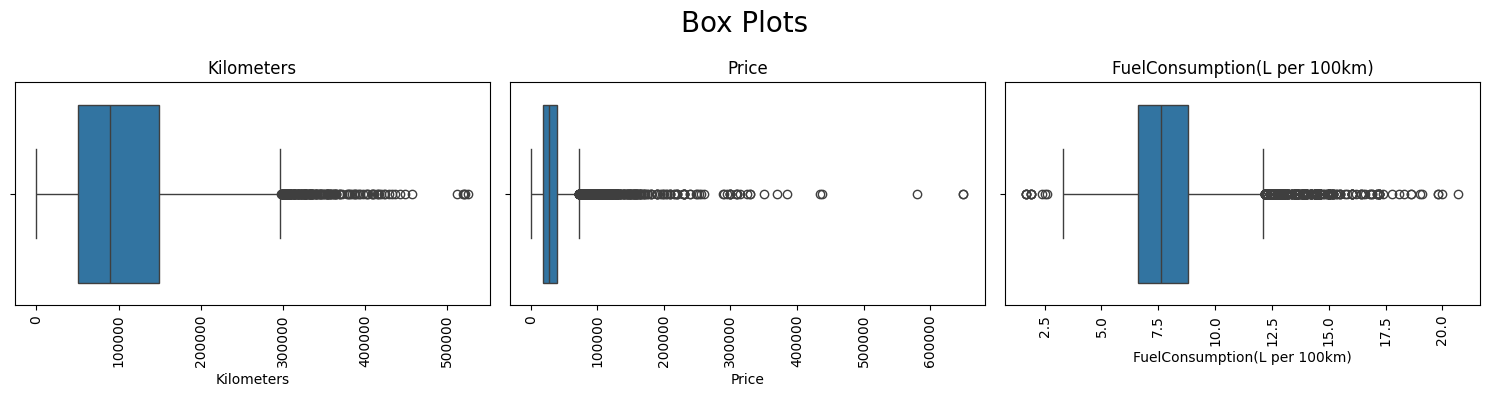

In [489]:
#Plot box plot for Year, Kilometers, Price, FuelConsumption, and Price
cols = ['Kilometers', 'Price', 'FuelConsumption(L per 100km)']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Box Plots', fontsize=20)

for ax, col in zip(axes.flatten(), cols):
    plot = sns.boxplot(ax=ax, data=df_model, x=col)
    ax.set_title(col)  # Optional: add a title for each subplot
    #Rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()
plt.show()

In [490]:
#Remove outliers based on IQR for Kilometers, Price, and FuelConsumption column
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]

df_model = remove_outliers(df, 'Kilometers')
df_model = remove_outliers(df, 'Price')
df_model = remove_outliers(df, 'FuelConsumption(L per 100km)')
print('Number of rows remaining:', df_model.shape[0])

Number of rows remaining: 12437


# Readying the data for modeling

In [491]:
df_model = df.copy()
#Label Encoding using LabelEncoder
le = LabelEncoder()
df_model['Brand'] = le.fit_transform(df_model['Brand'])
df_model['ExteriorColour'] = le.fit_transform(df_model['ExteriorColour'])

#One Hot Encoding for Transmission, DriveType, FuelType, Location, CylindersinEngine, BodyType
df_model = pd.get_dummies(df_model, columns=['Transmission', 'DriveType', 'FuelType', 'Location', 'CylindersinEngine', 'BodyType'], dtype=int)

In [492]:
# Split the data into train and test sets
X = df_model.drop('Price', axis=1)
y = df_model['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (10333, 42)
X_test shape: (2584, 42)


In [493]:
df_model.shape

(12917, 43)

In [494]:
print(df_model.head().to_markdown())

|    |   Brand |   Kilometers |   Price |   FuelConsumption(L per 100km) |   ExteriorColour |   Age |   Transmission_Automatic |   Transmission_Manual |   DriveType_4WD |   DriveType_AWD |   DriveType_Front |   DriveType_Rear |   FuelType_Diesel |   FuelType_Hybrid |   FuelType_LPG |   FuelType_Premium |   FuelType_Unleaded |   Location_ACT |   Location_NSW |   Location_NT |   Location_QLD |   Location_SA |   Location_TAS |   Location_VIC |   Location_WA |   CylindersinEngine_2 |   CylindersinEngine_3 |   CylindersinEngine_4 |   CylindersinEngine_5 |   CylindersinEngine_6 |   CylindersinEngine_8 |   CylindersinEngine_10 |   CylindersinEngine_12 |   BodyType_Commercial |   BodyType_Convertible |   BodyType_Coupe |   BodyType_Hatchback |   BodyType_Other |   BodyType_People Mover |   BodyType_SUV |   BodyType_Sedan |   BodyType_Ute / Tray |   BodyType_Wagon |
|---:|--------:|-------------:|--------:|-------------------------------:|-----------------:|------:|-------------------------:|--

# Models

In [508]:
# OLS
df_model_ols = df_model.copy()
drop_cols_ols = ['Brand', 'ExteriorColour']
df_model_ols.drop(drop_cols_ols, axis=1, inplace=True)
ols_model = sm.OLS(df_model_ols['Price'], sm.add_constant(df_model_ols.drop(['Price'], axis=1)))
ols_result = ols_model.fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     546.8
Date:                Tue, 02 Jul 2024   Prob (F-statistic):               0.00
Time:                        11:09:22   Log-Likelihood:            -1.4454e+05
No. Observations:               12917   AIC:                         2.892e+05
Df Residuals:                   12882   BIC:                         2.894e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           